In [34]:
#Import numpy, pandas for data manipulation 
import numpy as np
import pandas as pd
import scipy 
import math
from scipy.stats import kurtosis
from scipy.stats import skew
from pandas.plotting import autocorrelation_plot
#Import matplotlib, seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Import the data
weather_data = pd.read_csv('weather_data_test.csv' , parse_dates=['datetime'], sep=';',decimal=',',infer_datetime_format=True)
# Check the shape of the dataset
#print (weather_data.shape)
# Select the datetime and the temperature columns
temp_df = weather_data[["datetime" , "T_mu"]]
#temp_df.head (10)

In [3]:
# Select the subset data from 2015 to 2919
mask = (temp_df['datetime'] >= '2016-01-01') & (temp_df['datetime'] <= '2019-05-21')
temp_df = temp_df.loc[mask]
# Reset the index
temp_df.set_index("datetime", inplace=True)
#temp_df.set_index("T_mu")
# Inspect first 5 rows and last 5 rows of the data
from IPython. display import display
display(temp_df.head (5))
display(temp_df.tail (5))

,T_mu
datetime,
2016-01-01,-4.5500
2016-01-02,-7.0000
2016-01-03,-8.7375
2016-01-04,-11.1750
2016-01-05,-17.6250


,T_mu
datetime,
2019-05-17,13.783333
2019-05-18,15.508333
2019-05-19,16.595833
2019-05-20,17.258333
2019-05-21,18.433333


In [4]:
#scipy.stats.describe(temp_df, ddof=1, bias=False)
temp_df.describe()

,T_mu
count,1228.000000
mean,6.302811
std,8.433225
min,-22.675000
25%,0.559375
50%,5.227083
75%,13.784375
max,26.145833


In [5]:
print( 'median: {}'.format(temp_df["T_mu"].median()))
print( 'kurtosis: {}'.format( kurtosis(temp_df['T_mu'])))
print( 'skewness: {}'.format( skew(temp_df['T_mu'])))
mask1 = (temp_df['T_mu'] >= -3*temp_df["T_mu"].std()+temp_df["T_mu"].mean()) & (temp_df['T_mu'] <= 3*temp_df["T_mu"].std()+temp_df["T_mu"].mean())
filtered = temp_df.loc[mask1]
print('percentage of observed values in interval -3*SD, +3*SD: {}'.format(filtered.count()/temp_df.count()*100))

median: 5.227083333333333
kurtosis: -0.4413586752139138
skewness: -0.10279325720538766
percentage of observed values in interval -3*SD, +3*SD: T_mu    99.837134
dtype: float64


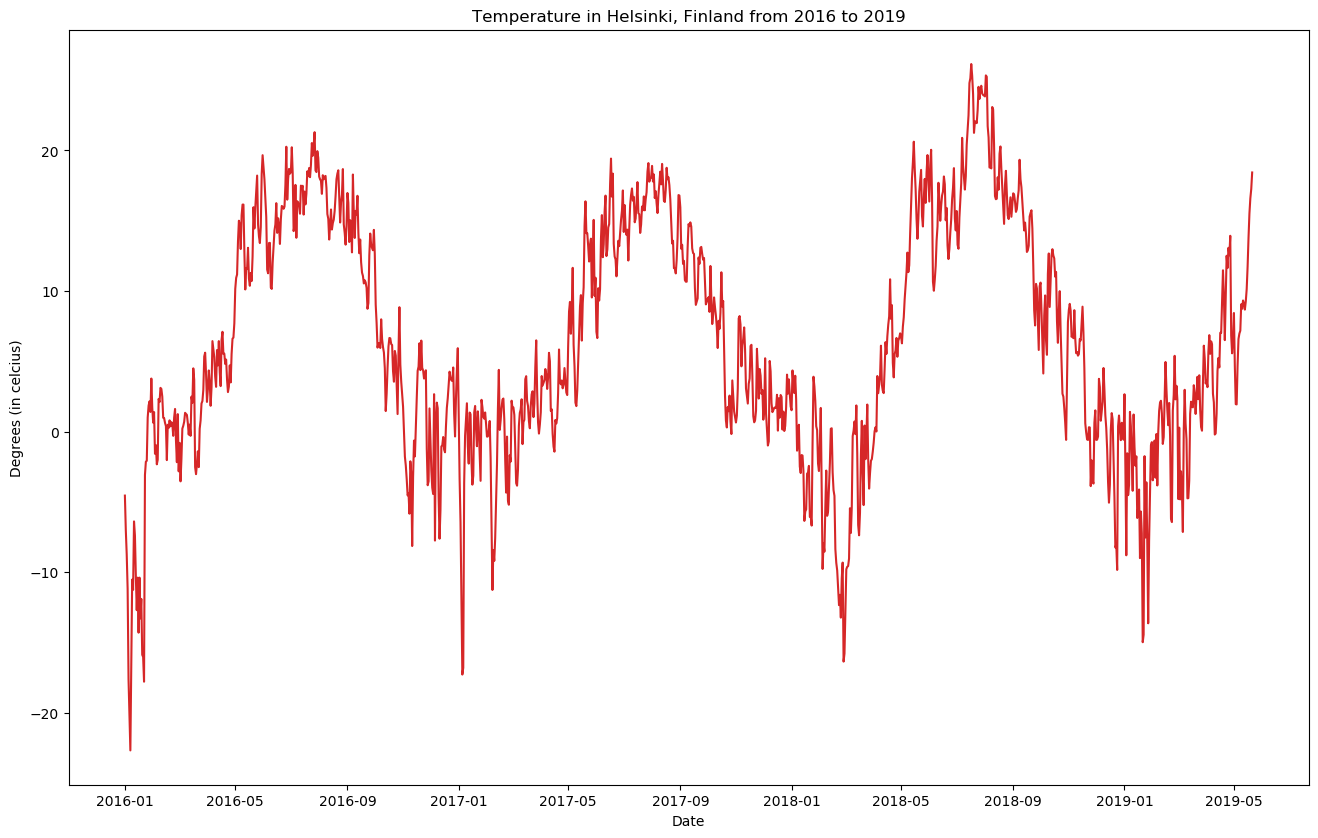

In [6]:
# Plot the daily temperature change
plt.figure(figsize=(16,10) ,dpi=100)
plt.plot(temp_df.index,temp_df.T_mu, color='tab:red')
plt.gca().set(title="Temperature in Helsinki, Finland from 2016 to 2019", xlabel='Date',ylabel='Degrees (in celcius)' )
plt.show()

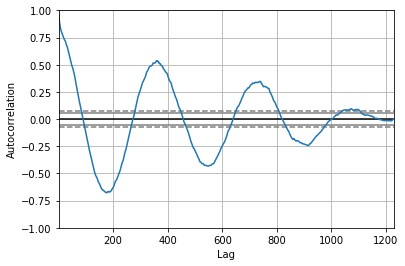

In [7]:
autocorrelation_plot(temp_df)
plt.show()

# p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.                                                                                                   p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

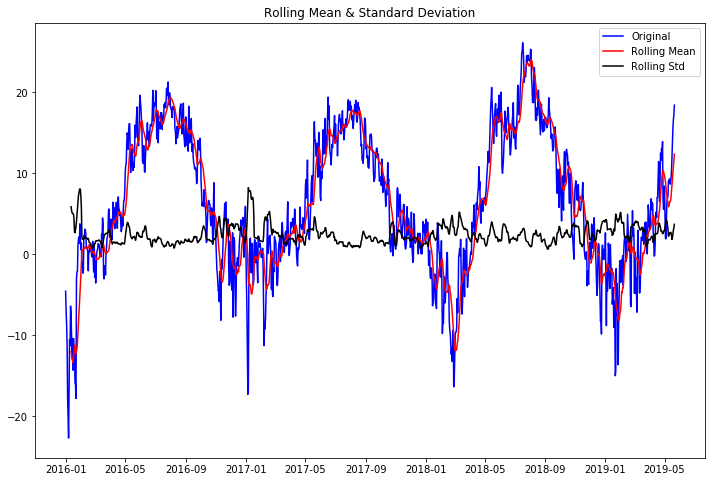

Results of Dickey-Fuller Test:
p-value = 0.0819. The series is likely non-stationary.
Test Statistic                   -2.656101
p-value                           0.081948
#Lags Used                       14.000000
Number of Observations Used    1213.000000
Critical Value (1%)              -3.435752
Critical Value (5%)              -2.863926
Critical Value (10%)             -2.568040
dtype: float64


In [9]:
test_stationarity(temp_df['T_mu'])

In [10]:
# from statsmodels.tsa.stattools import adfuller
# def adf_test(series, **kw):  
#     result = adfuller(series)
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))
# adf_test(temp_df)

# Replacing infinite with nan 
#temp_df=temp_df.dropna(how="any", inplace=True)
#temp_df = temp_df.fillna("", inplace=False)
#temp_df=temp_df.fillna(temp_df.mean(), inplace=True)
#temp_df=temp_df.replace([np.inf, -np.inf], np.nan)
# Dropping all the rows with nan values 
#temp_df=temp_df.dropna() 

In [11]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary')

kpss_test(temp_df)

KPSS Statistic: 0.13405877295616628
p-value: 0.1
num lags: 23
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [12]:
from arch.unitroot import PhillipsPerron
def pp_test(series, **kw): 
    pp = PhillipsPerron(series)
    print(pp)
pp_test(temp_df)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.781
P-value                         0.003
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Transformation

In [47]:
first_diff = temp_df.T_mu - temp_df.T_mu.shift(1)
first_diff=first_diff.dropna(inplace = False)

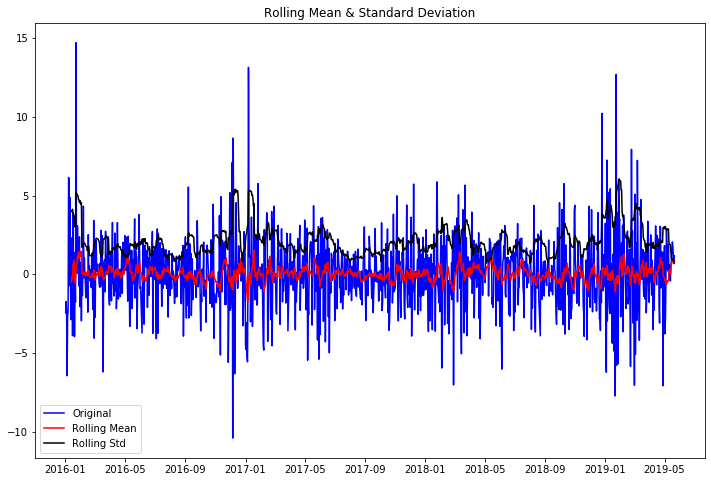

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.241618e+01
p-value                        4.235621e-23
#Lags Used                     1.300000e+01
Number of Observations Used    1.213000e+03
Critical Value (1%)           -3.435752e+00
Critical Value (5%)           -2.863926e+00
Critical Value (10%)          -2.568040e+00
dtype: float64


In [14]:
test_stationarity(first_diff, window = 12)

In [15]:
kpss_test(first_diff)

KPSS Statistic: 0.0632556115687029
p-value: 0.1
num lags: 23
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [16]:
pp_test(first_diff)

     Phillips-Perron Test (Z-tau)    
Test Statistic                -43.218
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [17]:
import statsmodels.api as sm
order_aic_bic =[]
for p in range(5):
# Loop over MA order
    for q in range(5):
# Fit model
        arima_mod = sm.tsa.statespace.SARIMAX(first_diff, order=(p,0,q))
        results = arima_mod.fit(disp=0)
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

In [18]:
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic
19  3  4  5417.250680  5458.149300
23  4  3  5418.470885  5459.369504
7   1  2  5423.774105  5444.223415
11  2  1  5424.109822  5444.559132
24  4  4  5424.549058  5470.560005
12  2  2  5425.581651  5451.143288
8   1  3  5425.717018  5451.278655
16  3  1  5425.943787  5451.505424
9   1  4  5426.284145  5456.958110
21  4  1  5426.795360  5457.469325
17  3  2  5427.012514  5457.686479
13  2  3  5427.198149  5457.872114
18  3  3  5427.406574  5463.192866
14  2  4  5428.164060  5463.950352
22  4  2  5428.216902  5464.003195
4   0  4  5430.278665  5455.840302
6   1  1  5434.503724  5449.840706
3   0  3  5446.013661  5466.462971
20  4  0  5447.342767  5472.904404
2   0  2  5457.458334  5472.795316
15  3  0  5462.141286  5482.590596
10  2  0  5467.476628  5482.813611
0   0  0  5486.994715  5492.107043
1   0  1  5488.024898  5498.249553
5   1  0  5488.292433  5498.517088


In [20]:
# Sort by BIC
print(order_df.sort_values('bic'))

    p  q          aic          bic
7   1  2  5423.774105  5444.223415
11  2  1  5424.109822  5444.559132
6   1  1  5434.503724  5449.840706
12  2  2  5425.581651  5451.143288
8   1  3  5425.717018  5451.278655
16  3  1  5425.943787  5451.505424
4   0  4  5430.278665  5455.840302
9   1  4  5426.284145  5456.958110
21  4  1  5426.795360  5457.469325
17  3  2  5427.012514  5457.686479
13  2  3  5427.198149  5457.872114
19  3  4  5417.250680  5458.149300
23  4  3  5418.470885  5459.369504
18  3  3  5427.406574  5463.192866
14  2  4  5428.164060  5463.950352
22  4  2  5428.216902  5464.003195
3   0  3  5446.013661  5466.462971
24  4  4  5424.549058  5470.560005
2   0  2  5457.458334  5472.795316
20  4  0  5447.342767  5472.904404
15  3  0  5462.141286  5482.590596
10  2  0  5467.476628  5482.813611
0   0  0  5486.994715  5492.107043
1   0  1  5488.024898  5498.249553
5   1  0  5488.292433  5498.517088


# AIC least for p=3 and q=4 and BIC least for p=1 and q=2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

                               SARIMAX Results                                
Dep. Variable:                   T_mu   No. Observations:                 1227
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -2700.625
Date:                Sun, 04 Oct 2020   AIC                           5417.251
Time:                        23:30:51   BIC                           5458.149
Sample:                             0   HQIC                          5432.640
                               - 1227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1043      0.056     -1.875      0.061      -0.213       0.005
ar.L2         -0.4933      0.044    -11.285      0.000      -0.579      -0.408
ar.L3          0.5889      0.058     10.240      0.0

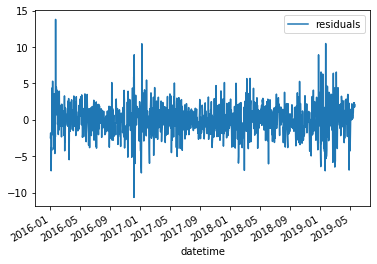

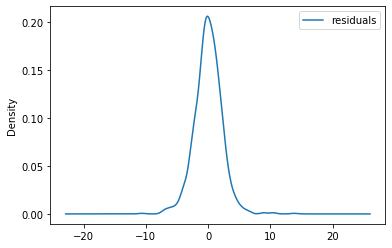

         residuals
count  1227.000000
mean      0.038817
std       2.187322
min     -10.644968
25%      -1.188197
50%       0.038690
75%       1.350299
max      13.801652


In [39]:
mod = sm.tsa.statespace.SARIMAX(first_diff, order=(3,0,4))
results = mod.fit()
print(results.summary())
# plot residual errors
residuals = pd.DataFrame(results.resid, columns=['residuals'])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [40]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=False)
pred_ci = pred.conf_int()

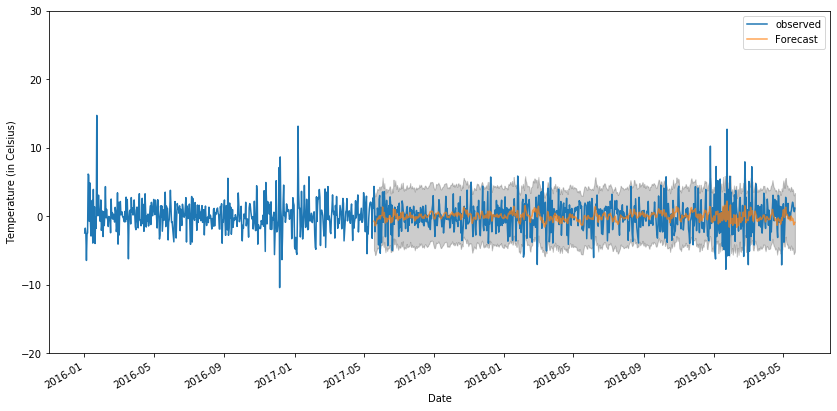

In [41]:
ax = first_diff.plot(label='observed')
#ax = first_diff.T_mu['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
first_diff.head(10)
y_forecasted=pred.predicted_mean
y_truth=first_diff[500:].values
mse = math.sqrt(mean_squared_error(y_truth, y_forecasted).mean())
print("Mean Squared Error of forecasts is {}".format(round(mse, 2)))

Mean Squared Error of forecasts is 2.15


# BIC MODEL

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                   T_mu   No. Observations:                 1227
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2707.887
Date:                Sun, 04 Oct 2020   AIC                           5423.774
Time:                        23:31:25   BIC                           5444.223
Sample:                             0   HQIC                          5431.469
                               - 1227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6464      0.052     12.462      0.000       0.545       0.748
ma.L1         -0.7185      0.053    -13.635      0.000      -0.822      -0.615
ma.L2         -0.1310      0.026     -5.081      0.0

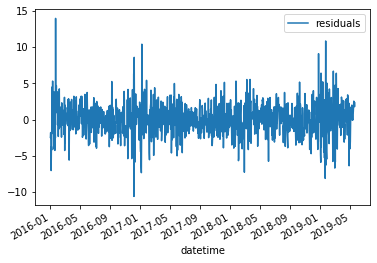

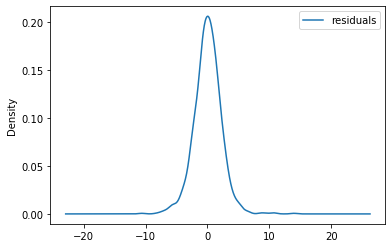

         residuals
count  1227.000000
mean      0.039404
std       2.199876
min     -10.605521
25%      -1.161499
50%       0.080632
75%       1.358330
max      13.966520


In [43]:
mod = sm.tsa.statespace.SARIMAX(first_diff, order=(1,0,2))
results = mod.fit()
print(results.summary())
# plot residual errors
residuals = pd.DataFrame(results.resid, columns=['residuals'])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [44]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=False)
pred_ci = pred.conf_int()

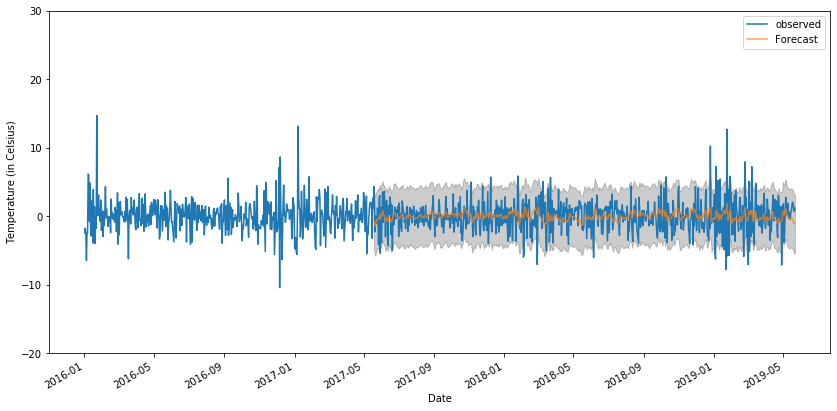

In [45]:
ax = first_diff.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
first_diff.head(10)
y_forecasted=pred.predicted_mean
y_truth=first_diff[500:].values
mse = math.sqrt(mean_squared_error(y_truth, y_forecasted).mean())
print("Mean Squared Error of forecasts is {}".format(round(mse, 2)))

Mean Squared Error of forecasts is 2.16
